# Ladder network
- Based on: https://github.com/abhiskk/ladder/blob/master/ladder/
- An unsqueeze operation was added **bn_hat_z_layers**

In [1]:
import numpy as np
import torch
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim import SGD

In [2]:
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size':18})
%matplotlib inline

In [3]:
import utils_CLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

![title](ladder_network_overview.jpg)

## I. Create a sequential model of StackedEncoders   
- encoders = torch.nn.Sequential()
  - store each encoder
  - store a reference to each encoder:
    - for i in range(n_encoders):   
          encoder = Encoder(...)   
          encoders_ref.append(encoder_ref)   
          encoders.add_module(encoder_ref, encoder)   
          
## II. For each epoch, StackedEncoders call:
#### 1. forward_noise 
  - on labelled data   
  - on unlabelled data
  
#### 2.  get_encoders_tilde_z (produced by 1)

### 1. forward_noise (on labelled data)
- create noise
- create dirty data (h) $h = x + noise$
- **store** the bottom h (h1) (without gradients)  $\overset{\sim}{z}$ (retrieved in 7)
- For each encoder we send forward_noise(h):
  - linear transformation: $y=xA^T$ (z_pre)
  - Batch_Normalization (z_pre_norm)
  - Noise addition $\overset{\sim}{z}$
  - **Store** a copy of $\overset{\sim}{z}$ (retrieved in 3)
  - Batch Norm correction
  - Activation (h)
  - Return (h)

### 2. forward_noise (on unlabelled data)
- same as 1

### 3. get_encoders_tilde_z
 - Get all $\overset{\sim}{z}$ obtained in forward_noise
 - Append them in an array and reverse it
 
### 4. forward_clean (unlabelled_data)
- For each encoder we send forward_clean(h):
  - linear transformation: $y=xA^T$ (z_pre)
  - **Store** a copy of (**buffer_z_pre**) (retrieved in 5)
  - Batch_Normalization (z)
  - **Store** a copy of (**buffer_z**) (retrieved in 6)
  - Batch_Normalization Gamm_Beta (z_gb)   <-check why
  - Activation (h)
  - Return (h)
  
### 5. get_encoders_z_pre (created in 4)
 - Get all **buffer_z_pre** obtained in forward_noise
 - Append them in an array and reverse it
 
### 6. get_encoders_z (created in 4)
 - Get all **buffer_z** obtained in forward_noise
 - Append them in an array and reverse it
 
### 7. buffer_tilde_z_bottom (created in 4)
-  **Store** the bottom $\overset{\sim}{z}$ created in 1

### 8. forward_decoders( $\overset{\sim}{z}$_unlabelled (from 3),    output_noise_unlabelled (from 2), bottom $\overset{\sim}{z}$_unlabelled (from 2))
### - returns $\hat{z}$ (weighted ($\upsilon$) sum of $\overset{\sim}{z}$ and a prior $\mu$) 
### $\hat{z} = \upsilon * \overset{\sim}{z} + (1 - \upsilon) * \mu$

- Batch Normalization on encoder_output  
- for each decoder:
  - get the corresponding $\overset{\sim}{z}$ from $\boldsymbol{\overset{\sim}{z}}$ (tilde_z from 3)
  - apply u=decoder.forward($\overset{\sim}{z}$, u) (in the first case u is encoder_output)
    - apply the combinatior function g(tilde_z, u). It combines the lateral noisy activation signal $\overset{\sim}{z}$ and the reconstruction from layer $\hat{z}^{(l+1)}$
    - In the first case the combinator will use the last $\overset{\sim}{z}$ and the encoder_output
    - In the combinator the functions $\mu$ and $\upsilon$ are model as expresive non linearities and have trainable parameters ($a1_i$...$a5_i$). e.g:
    - $\mu$ = a1 \* sigmoid(a2 \* output + a3) + a4 \* output + a5
    - $\upsilon$ = a6 \* sigmoid(a7 \* output + a8) + a9 \* output + a10
    - $\mu$ and $\upsilon$ have the same shape as u (output for the first case)
    - $\hat{z}$ = ($\overset{\sim}{z} - \mu) * \upsilon) + \mu$    (equivalent to first formula in (8))
    
### 9-10. Append unlabelled to preactivations and to activations
### 11. Batch norm $\hat{z}$ using z_pre  
  - It uses mean(z_pre) but the std is obtained with random noise (?) 
  - Warning: I added an unsqueeze operation to match mm dimensions

# Classes

### Encoder

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, d_in, d_out, activation_type,
                 train_bn_scaling, noise_level, use_cuda):
        super(Encoder, self).__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.activation_type = activation_type
        self.train_bn_scaling = train_bn_scaling
        self.noise_level = noise_level
        self.use_cuda = use_cuda

        # Encoder
        # Encoder only uses W matrix, no bias
        self.linear = torch.nn.Linear(d_in, d_out, bias=False)
        self.linear.weight.data = torch.randn(self.linear.weight.data.size()) / np.sqrt(d_in)

        # Batch Normalization
        # For Relu Beta of batch-norm is redundant, hence only Gamma is trained
        # For Softmax Beta, Gamma are trained
        # batch-normalization bias
        self.bn_normalize_clean = torch.nn.BatchNorm1d(d_out, affine=False)
        self.bn_normalize = torch.nn.BatchNorm1d(d_out, affine=False)
        if self.use_cuda:
            self.bn_beta = Parameter(torch.cuda.FloatTensor(1, d_out))
        else:
            self.bn_beta = Parameter(torch.FloatTensor(1, d_out))
        self.bn_beta.data.zero_()
        if self.train_bn_scaling:
            # batch-normalization scaling
            if self.use_cuda:
                self.bn_gamma = Parameter(torch.cuda.FloatTensor(1, d_out))
                self.bn_gamma.data = torch.ones(self.bn_gamma.size()).cuda()
            else:
                self.bn_gamma = Parameter(torch.FloatTensor(1, d_out))
                self.bn_gamma.data = torch.ones(self.bn_gamma.size())

        # Activation
        if activation_type == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_type == 'softmax':
            self.activation = torch.nn.Softmax()
        else:
            raise ValueError("invalid Acitvation type")

        # buffer for z_pre, z which will be used in decoder cost
        self.buffer_z_pre = None
        self.buffer_z = None
        # buffer for tilde_z which will be used by decoder for reconstruction
        self.buffer_tilde_z = None

    def bn_gamma_beta(self, x):
        if self.use_cuda:
            ones = Parameter(torch.ones(x.size()[0], 1).cuda())
        else:
            ones = Parameter(torch.ones(x.size()[0], 1))
        t = x + ones.mm(self.bn_beta)
        if self.train_bn_scaling:
            t = torch.mul(t, ones.mm(self.bn_gamma))
        return t

    def forward_clean(self, h):
        z_pre = self.linear(h)
        # Store z_pre, z to be used in calculation of reconstruction cost
        self.buffer_z_pre = z_pre.detach().clone()
        z = self.bn_normalize_clean(z_pre)
        self.buffer_z = z.detach().clone()
        z_gb = self.bn_gamma_beta(z)
        h = self.activation(z_gb)
        return h

    def forward_noise(self, tilde_h):
        # z_pre will be used in the decoder cost
        z_pre = self.linear(tilde_h)
        z_pre_norm = self.bn_normalize(z_pre)
        # Add noise
        noise = np.random.normal(loc=0.0, scale=self.noise_level, size=z_pre_norm.size())
        if self.use_cuda:
            noise = Variable(torch.cuda.FloatTensor(noise))
        else:
            noise = Variable(torch.FloatTensor(noise))
        # tilde_z will be used by decoder for reconstruction
        tilde_z = z_pre_norm + noise
        # store tilde_z in buffer
        self.buffer_tilde_z = tilde_z
        z = self.bn_gamma_beta(tilde_z)
        h = self.activation(z)
        return h

In [5]:
class StackedEncoders(torch.nn.Module):
    def __init__(self, d_in, d_encoders, activation_types,
                 train_batch_norms, noise_std, use_cuda):
        super(StackedEncoders, self).__init__()
        self.buffer_tilde_z_bottom = None
        self.encoders_ref = []
        self.encoders = torch.nn.Sequential()
        self.noise_level = noise_std
        self.use_cuda = use_cuda
        n_encoders = len(d_encoders)
        for i in range(n_encoders):
            if i == 0:
                d_input = d_in
            else:
                d_input = d_encoders[i - 1]
            d_output = d_encoders[i]
            activation = activation_types[i]
            train_batch_norm = train_batch_norms[i]
            encoder_ref = "encoder_" + str(i)
            encoder = Encoder(d_input, d_output, activation, train_batch_norm, noise_std, use_cuda)
            self.encoders_ref.append(encoder_ref)
            self.encoders.add_module(encoder_ref, encoder)

    def forward_clean(self, x):
        h = x
        for e_ref in self.encoders_ref:
            encoder = getattr(self.encoders, e_ref)
            h = encoder.forward_clean(h)
        return h

    def forward_noise(self, x):
        noise = np.random.normal(loc=0.0, scale=self.noise_level, size=x.size())
        if self.use_cuda:
            
            noise = Variable(torch.cuda.FloatTensor(noise))
            #noise = Variable(torch.FloatTensor(noise)).cuda()
        else:
            noise = Variable(torch.FloatTensor(noise))
        h = x + noise
        self.buffer_tilde_z_bottom = h.clone()
        # pass through encoders
        for e_ref in self.encoders_ref:
            encoder = getattr(self.encoders, e_ref)
            h = encoder.forward_noise(h)
        return h

    def get_encoders_tilde_z(self, reverse=True):
        tilde_z_layers = []
        for e_ref in self.encoders_ref:
            encoder = getattr(self.encoders, e_ref)
            tilde_z = encoder.buffer_tilde_z.clone()
            tilde_z_layers.append(tilde_z)
        if reverse:
            tilde_z_layers.reverse()
        return tilde_z_layers

    def get_encoders_z_pre(self, reverse=True):
        z_pre_layers = []
        for e_ref in self.encoders_ref:
            encoder = getattr(self.encoders, e_ref)
            z_pre = encoder.buffer_z_pre.clone()
            z_pre_layers.append(z_pre)
        if reverse:
            z_pre_layers.reverse()
        return z_pre_layers

    def get_encoders_z(self, reverse=True):
        z_layers = []
        for e_ref in self.encoders_ref:
            encoder = getattr(self.encoders, e_ref)
            z = encoder.buffer_z.clone()
            z_layers.append(z)
        if reverse:
            z_layers.reverse()
        return z_layers

### decoder

In [6]:
class Decoder(torch.nn.Module):
    def __init__(self, d_in, d_out, use_cuda):
        super(Decoder, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.use_cuda = use_cuda

        if self.use_cuda:
            self.a1 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a2 = Parameter(1. * torch.ones(1, d_in).cuda())
            self.a3 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a4 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a5 = Parameter(0. * torch.ones(1, d_in).cuda())

            self.a6 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a7 = Parameter(1. * torch.ones(1, d_in).cuda())
            self.a8 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a9 = Parameter(0. * torch.ones(1, d_in).cuda())
            self.a10 = Parameter(0. * torch.ones(1, d_in).cuda())
        else:
            self.a1 = Parameter(0. * torch.ones(1, d_in))
            self.a2 = Parameter(1. * torch.ones(1, d_in))
            self.a3 = Parameter(0. * torch.ones(1, d_in))
            self.a4 = Parameter(0. * torch.ones(1, d_in))
            self.a5 = Parameter(0. * torch.ones(1, d_in))

            self.a6 = Parameter(0. * torch.ones(1, d_in))
            self.a7 = Parameter(1. * torch.ones(1, d_in))
            self.a8 = Parameter(0. * torch.ones(1, d_in))
            self.a9 = Parameter(0. * torch.ones(1, d_in))
            self.a10 = Parameter(0. * torch.ones(1, d_in))


        if self.d_out is not None:
            self.V = torch.nn.Linear(d_in, d_out, bias=False)
            self.V.weight.data = torch.randn(self.V.weight.data.size()) / np.sqrt(d_in)
            # batch-normalization for u
            self.bn_normalize = torch.nn.BatchNorm1d(d_out, affine=False)

        # buffer for hat_z_l to be used for cost calculation
        self.buffer_hat_z_l = None

    def g(self, tilde_z_l, u_l):
        if self.use_cuda:
            ones = Parameter(torch.ones(tilde_z_l.size()[0], 1).cuda())
        else:
            ones = Parameter(torch.ones(tilde_z_l.size()[0], 1))

        b_a1 = ones.mm(self.a1)
        b_a2 = ones.mm(self.a2)
        b_a3 = ones.mm(self.a3)
        b_a4 = ones.mm(self.a4)
        b_a5 = ones.mm(self.a5)

        b_a6 = ones.mm(self.a6)
        b_a7 = ones.mm(self.a7)
        b_a8 = ones.mm(self.a8)
        b_a9 = ones.mm(self.a9)
        b_a10 = ones.mm(self.a10)

        mu_l = torch.mul(b_a1, torch.sigmoid(torch.mul(b_a2, u_l) + b_a3)) + \
               torch.mul(b_a4, u_l) + \
               b_a5

        v_l = torch.mul(b_a6, torch.sigmoid(torch.mul(b_a7, u_l) + b_a8)) + \
              torch.mul(b_a9, u_l) + \
              b_a10

        hat_z_l = torch.mul(tilde_z_l - mu_l, v_l) + mu_l

        return hat_z_l

    def forward(self, tilde_z_l, u_l):
        # hat_z_l will be used for calculating decoder costs
        hat_z_l = self.g(tilde_z_l, u_l)
        # store hat_z_l in buffer for cost calculation
        self.buffer_hat_z_l = hat_z_l

        if self.d_out is not None:
            t = self.V.forward(hat_z_l)
            u_l_below = self.bn_normalize(t)
            return u_l_below
        else:
            return None

In [7]:
class StackedDecoders(torch.nn.Module):
    def __init__(self, d_in, d_decoders, image_size, use_cuda):
        super(StackedDecoders, self).__init__()
        self.bn_u_top = torch.nn.BatchNorm1d(d_in, affine=False)
        self.decoders_ref = []
        self.decoders = torch.nn.Sequential()
        self.use_cuda = use_cuda
        n_decoders = len(d_decoders)
        for i in range(n_decoders):
            if i == 0:
                d_input = d_in
            else:
                d_input = d_decoders[i - 1]
            d_output = d_decoders[i]
            decoder_ref = "decoder_" + str(i)
            decoder = Decoder(d_input, d_output, use_cuda)
            self.decoders_ref.append(decoder_ref)
            self.decoders.add_module(decoder_ref, decoder)

        self.bottom_decoder = Decoder(image_size, None, use_cuda)

    def forward(self, tilde_z_layers, u_top, tilde_z_bottom):
        # Note that tilde_z_layers should be in reversed order of encoders
        hat_z = []
        u = self.bn_u_top(u_top)
        for i in range(len(self.decoders_ref)):
            d_ref = self.decoders_ref[i]
            decoder = getattr(self.decoders, d_ref)
            tilde_z = tilde_z_layers[i]
            u = decoder.forward(tilde_z, u)
            hat_z.append(decoder.buffer_hat_z_l)
        self.bottom_decoder.forward(tilde_z_bottom, u)
        hat_z_bottom = self.bottom_decoder.buffer_hat_z_l.clone()
        hat_z.append(hat_z_bottom)
        return hat_z

    def bn_hat_z_layers(self, hat_z_layers, z_pre_layers):
        # TODO: Calculate batchnorm using GPU Tensors.
        assert len(hat_z_layers) == len(z_pre_layers)
        hat_z_layers_normalized = []
        for i, (hat_z, z_pre) in enumerate(zip(hat_z_layers, z_pre_layers)):
            if self.use_cuda:
                ones = Variable(torch.ones(z_pre.size()[0], 1).cuda())
            else:
                ones = Variable(torch.ones(z_pre.size()[0], 1))
            mean = torch.mean(z_pre, 0)
            mean.unsqueeze_(0) # <---- ADDED BY OMM
            noise_var = np.random.normal(loc=0.0, scale=1 - 1e-10, size=z_pre.size())
            if self.use_cuda:
                var = np.var(z_pre.data.cpu().numpy() + noise_var, axis=0).reshape(1, z_pre.size()[1])
            else:
                var = np.var(z_pre.data.numpy() + noise_var, axis=0).reshape(1, z_pre.size()[1])
            var = Variable(torch.FloatTensor(var))
            if self.use_cuda:
                hat_z = hat_z.cpu()
                ones = ones.cpu()
                mean = mean.cpu()
            hat_z_normalized = torch.div(hat_z - ones.mm(mean), ones.mm(torch.sqrt(var + 1e-10)))
            if self.use_cuda:
                hat_z_normalized = hat_z_normalized.cuda()
            hat_z_layers_normalized.append(hat_z_normalized)
        return hat_z_layers_normalized

---

# ladder

In [8]:
class Ladder(torch.nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes, encoder_activations, encoder_train_bn_scaling,
                noise_std, use_cuda):
        super(Ladder, self).__init__()
        self.use_cuda = use_cuda
        decoder_in = encoder_sizes[-1]
        encoder_in = decoder_sizes[-1]
        self.se = StackedEncoders(encoder_in, encoder_sizes, encoder_activations,
                                  encoder_train_bn_scaling, noise_std, use_cuda)
        self.de = StackedDecoders(decoder_in, decoder_sizes, encoder_in, use_cuda)
        
        self.bn_image = torch.nn.BatchNorm1d(encoder_in, affine=False)
        
    def forward_encoders_clean(self, data):
        return self.se.forward_clean(data)
        
    def forward_encoders_noise(self, data):
        return self.se.forward_noise(data)
    
    def forward_decoders(self, tilde_z_layers, encoder_output, tilde_z_bottom):
        return self.de.forward(tilde_z_layers, encoder_output, tilde_z_bottom)
        
    def get_encoders_tilde_z(self, reverse=True):
        return self.se.get_encoders_tilde_z(reverse)

    def get_encoders_z_pre(self, reverse=True):
        return self.se.get_encoders_z_pre(reverse)

    def get_encoder_tilde_z_bottom(self):
        return self.se.buffer_tilde_z_bottom.clone()

    def get_encoders_z(self, reverse=True):
        return self.se.get_encoders_z(reverse)

    def decoder_bn_hat_z_layers(self, hat_z_layers, z_pre_layers):
        return self.de.bn_hat_z_layers(hat_z_layers, z_pre_layers)

---

# Data

In [9]:
root='data/'
train_set = dset.MNIST(root=root, train=True, download=True)
test_set = dset.MNIST(root=root, train=False, download=True)

In [10]:
# Load MNIST and permutate it
X_train = train_set.train_data
y_train = train_set.train_labels
# Normalize it
X_train = np.multiply(X_train, 1./255.)
# Flatten the rows and columns
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
randomize = np.arange(X_train.shape[0])
np.random.shuffle(randomize)
# Get a ratio from labeled and unlabeled data
labeled_ratio = .15
X_train_labelled = X_train[randomize[:int(np.round(X_train.shape[0] * labeled_ratio))]] 
y_train = y_train[randomize[:int(np.round(X_train.shape[0] * labeled_ratio))]]
X_train_unlabelled = X_train[randomize[int(np.round(X_train.shape[0] * labeled_ratio)):]] 
# Covert to tensor
X_train_labelled = X_train_labelled.type(torch.Tensor)
X_train_unlabelled = X_train_unlabelled.type(torch.Tensor)
#X_train = np.expand_dims(X_train,-1)
print(f'X_train_labelled = {np.shape(X_train_labelled)}, {labeled_ratio*100:.0f}% of {X_train.shape[0]}')
print(f'X_train_unlabelled = {np.shape(X_train_unlabelled)}, {(1-labeled_ratio)*100:.0f}% of {X_train.shape[0]}')
print(f'labels = {np.shape(y_train)}')

X_train_labelled = torch.Size([9000, 784]), 15% of 60000
X_train_unlabelled = torch.Size([51000, 784]), 85% of 60000
labels = torch.Size([9000])


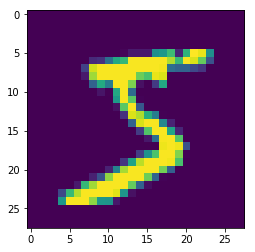

In [11]:
plt.imshow(np.reshape(X_train[0],[28,28]))

In [12]:
# Test data
X_test = test_set.test_data
y_test = test_set.test_labels
X_test = np.multiply(X_test, 1./255)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
X_test = X_test.type(torch.Tensor)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)
X_test = Variable(X_test, requires_grad = False)
y_test = Variable(y_test, requires_grad = False)

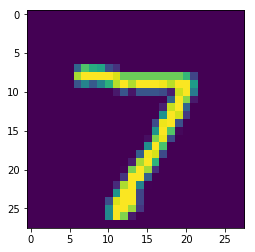

In [13]:
plt.imshow(np.reshape(X_test[0],[28,28]))

---

# Ladder

In [14]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [28]:
# Configure the Ladder
noise_std = 0.2
encoder_sizes = [1000, 500, 250, 250, 250, 10]
decoder_sizes = [250, 250, 250, 500, 1000, 784]
unsupervised_costs_lambda = [0.1, 0.1, 0.1, 0.1, 0.1, 10., 1000.]  # 0.1, 0.1, 0.1, 0.1, 0.1, 10., 1000.
encoder_activations = ["relu", "relu", "relu", "relu", "relu", "softmax"]
encoder_train_bn_scaling = [False, False, False, False, False, True]

use_cuda = True 

ladder = Ladder(encoder_sizes, decoder_sizes, encoder_activations,
                    encoder_train_bn_scaling, noise_std, use_cuda)

epochs = 20
decay_epoch = 15
learning_rate = 0.02
initial_learning_rate = learning_rate
optimizer = Adam(ladder.parameters(), lr = learning_rate)
loss_supervised = torch.nn.CrossEntropyLoss()
loss_unsupervised = torch.nn.MSELoss()

if use_cuda:
    ladder.cuda()

batch_size = 100
batch_times = np.shape(X_train_labelled)[0]//batch_size
batch_size_unlabelled = int(np.shape(X_train_unlabelled)[0] / batch_size)

supervised_costs = []
unsupervised_costs = []
cost_main = []
y_pred_all = []

agg_cost = 0.
agg_supervised_cost = 0.
agg_unsupervised_cost = 0.
num_batches = 0

for epoch in range(epochs):
    
    if epoch > decay_epoch:
        ratio = float(epochs - epoch) / (epochs - decay_epoch)
        learning_rate = learning_rate * ratio
        optimizer = Adam(ladder.parameters(), lr = learning_rate)
        
    for i in range(batch_times):
        
        if (i+1)%100==0 or i==batch_times-1: print(f'epoch = {epoch}, batch = {i+1}')
    
        ladder.train()
        optimizer.zero_grad()
        
        batch_train_labelled_images = torch.FloatTensor(X_train_labelled[i*batch_size:(i+1)*batch_size-1])
        batch_train_unlabelled_images = torch.FloatTensor(X_train_unlabelled[i*batch_size_unlabelled:(i+1)*batch_size_unlabelled-1])
        batch_train_labelled_labels = torch.LongTensor(y_train[i*batch_size:(i+1)*batch_size-1])
        
        if use_cuda:
            batch_train_labelled_images = batch_train_labelled_images.cuda()
            batch_train_unlabelled_images = batch_train_unlabelled_images.cuda()
            batch_train_labelled_labels = batch_train_labelled_labels.cuda()
        
        labelled_data = Variable(batch_train_labelled_images, requires_grad=False)
        unlabelled_data = Variable(batch_train_unlabelled_images, requires_grad=False)
        labelled_target = Variable(batch_train_labelled_labels)
        
        # encoders
        output_noise_labelled = ladder.forward_encoders_noise(labelled_data)            # 1
        output_noise_unlabelled = ladder.forward_encoders_noise(unlabelled_data)        # 2
        tilde_z_layers_unlabelled = ladder.get_encoders_tilde_z(reverse=True)           # 3
        output_clean_unlabelled = ladder.forward_encoders_clean(unlabelled_data)        # 4
        z_pre_layers_unlabelled = ladder.get_encoders_z_pre(reverse=True)               # 5
        z_layers_unlabelled = ladder.get_encoders_z(reverse=True)                       # 6
        tilde_z_bottom_unlabelled = ladder.get_encoder_tilde_z_bottom()                 # 7
        # decoders
        hat_z_layers_unlabelled = ladder.forward_decoders(tilde_z_layers_unlabelled,    
                                                      output_noise_unlabelled,
                                                      tilde_z_bottom_unlabelled)
        z_pre_layers_unlabelled.append(unlabelled_data)
        z_layers_unlabelled.append(unlabelled_data)
        
        bn_hat_z_layers_unlabelled = ladder.decoder_bn_hat_z_layers(hat_z_layers_unlabelled, 
                                                                z_pre_layers_unlabelled)
        # costs
        cost_supervised = loss_supervised.forward(output_noise_labelled, labelled_target)
        cost_unsupervised = 0.
        assert len(z_layers_unlabelled) == len(bn_hat_z_layers_unlabelled)
        for cost_lambda, z, bn_hat_z in zip(unsupervised_costs_lambda, z_layers_unlabelled, bn_hat_z_layers_unlabelled):
            c = cost_lambda * loss_unsupervised.forward(bn_hat_z, z)
            cost_unsupervised += c
    
        # backprop
        cost = cost_supervised + cost_unsupervised
        cost.backward()                  # if cost_supervised.backward is in , acc = 0.80
        optimizer.step()
    
        agg_cost += cost.item()
        agg_supervised_cost += cost_supervised.item()
        agg_unsupervised_cost += cost_unsupervised.item()
        num_batches += 1
        
        supervised_costs.append(cost_supervised.item())
        unsupervised_costs.append(cost_unsupervised.item())
        cost_main.append(cost.item())
        
    # eval
    ladder.eval()
    with torch.no_grad(): # So we don't run out of memory 
        if use_cuda:
            X_test = X_test.cuda()
        
        X_test_cuda = Variable(X_test)
        y_pred = ladder.forward_encoders_clean(X_test_cuda)
        y_pred_all.append(y_pred)

/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 0, batch = 90
epoch = 1, batch = 90
epoch = 2, batch = 90
epoch = 3, batch = 90
epoch = 4, batch = 90
epoch = 5, batch = 90
epoch = 6, batch = 90
epoch = 7, batch = 90
epoch = 8, batch = 90
epoch = 9, batch = 90
epoch = 10, batch = 90
epoch = 11, batch = 90
epoch = 12, batch = 90
epoch = 13, batch = 90
epoch = 14, batch = 90
epoch = 15, batch = 90
epoch = 16, batch = 90
epoch = 17, batch = 90
epoch = 18, batch = 90
epoch = 19, batch = 90


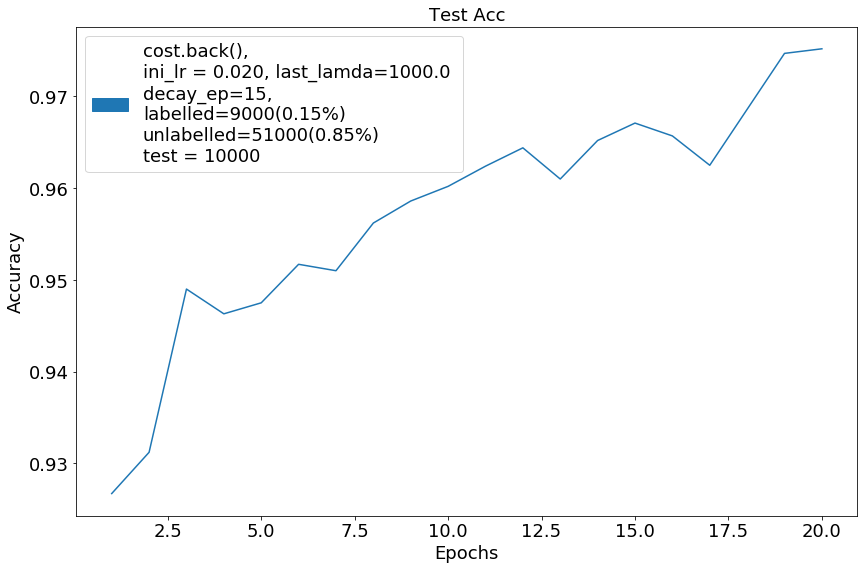

In [64]:
plt.figure(figsize=(14,9))
accuracies = []
for i in y_pred_all:
    pred_proba = i.data.cpu()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(np.arange(1,len(accuracies)+1),accuracies)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.title('Test Acc', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
notes = mpatches.Patch(color='#1F77B4', label=f'cost.back(), \nini_lr = {initial_learning_rate:.3f}, \
last_lamda={unsupervised_costs_lambda[-1]} \ndecay_ep={decay_epoch}, \nlabelled={np.shape(X_train_labelled)[0]}({labeled_ratio}%)\
\nunlabelled={np.shape(X_train_unlabelled)[0]}({1-labeled_ratio}%)\
\ntest = {np.shape(X_test)[0]}')
plt.legend(handles=[notes], fontsize=18)
plt.savefig(f'ladder_mnist_acc_{int(labeled_ratio*100)}%label.png', bbox_inches='tight')

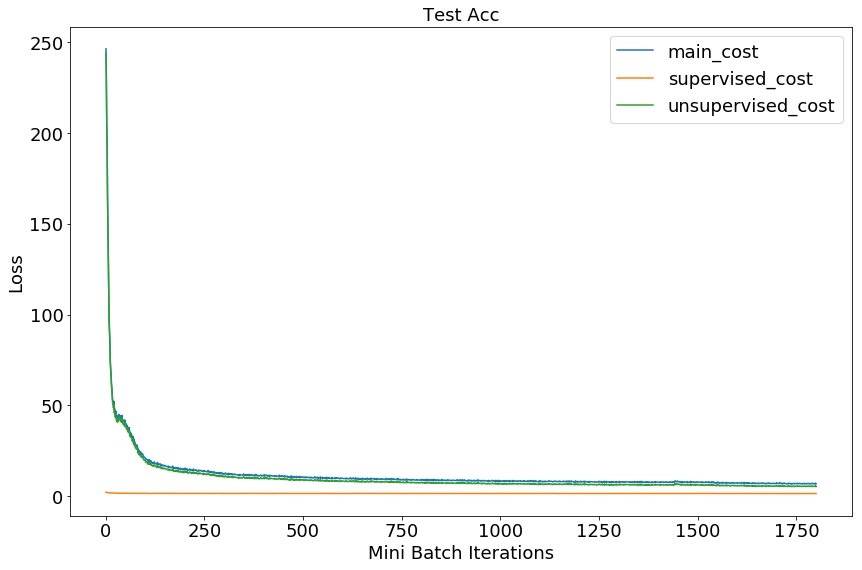

In [65]:
plt.figure(figsize=(14,9))
name_cost_main, = plt.plot(np.arange(1,len(cost_main)+1), cost_main, label='main_cost')
name_supervised_costs, = plt.plot(np.arange(1,len(supervised_costs)+1), supervised_costs, label='supervised_cost')
name_unsupervised_costs, = plt.plot(np.arange(1,len(unsupervised_costs)+1), unsupervised_costs, label='unsupervised_cost')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Mini Batch Iterations', fontsize=18)
plt.title('Test Acc', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(handles=[name_cost_main, name_supervised_costs, name_unsupervised_costs], fontsize=18)
plt.savefig(f'ladder_mnist_loss_{int(labeled_ratio*100)}%label.png', bbox_inches='tight')

# Encoder & decoder

In [ ]:
many_encoders = StackedEncoders(784, [1000, 500, 250, 250, 250, 10], 
                                ["relu", "relu", "relu", "relu", "relu", "softmax"], 
                                [False, False, False, False, False, True], 0.2, False)
many_decoders = StackedDecoders(10, [250, 250, 250, 500, 1000, 784], 784, False)

unsupervised_costs_lambda = [0.1, 0.1, 0.1, 0.1, 0.1, 10., 1000.]

current_lr = 0.002
optimizer = Adam(many_encoders.parameters(), lr = current_lr)
optimizer_decoder = Adam(many_decoders.parameters(), lr = current_lr)
loss_supervised = torch.nn.CrossEntropyLoss()
loss_unsupervised = torch.nn.MSELoss()

batch_size = 100
batch_times = np.shape(X_train_labelled)[0]//batch_size

supervised_costs=[]
many_encoders.train()

agg_cost = 0.
agg_supervised_cost = 0.
agg_unsupervised_cost = 0.
num_batches = 0

y_pred_all = []

for epoch in range(10):
    
    if epoch % 4 == 0:
        current_lr /= 2
        optimizer = Adam(many_encoders.parameters(), lr = current_lr)
        optimizer_decoder = Adam(many_encoders.parameters(), lr = current_lr)
    
    many_encoders.train()
    many_decoders.train()
    
    for i in range(batch_times):
        
        optimizer.zero_grad()
        optimizer_decoder.zero_grad()
        
        if (i+1)%100==0 or i==batch_times-1: print(f'epoch = {epoch}, batch = {i+1}')
            
        batch_train_labelled_images = torch.FloatTensor(X_train_labelled[i:i+int(np.round(batch_size*labeled_ratio))])
        batch_train_unlabelled_images = torch.FloatTensor(X_train_unlabelled[i:i+int(np.round(batch_size*(1-labeled_ratio)))])
        batch_train_labelled_labels = torch.LongTensor(y_train[i:i+int(np.round(batch_size*labeled_ratio))])
        
        labelled_data = Variable(batch_train_labelled_images, requires_grad=False)
        unlabelled_data = Variable(batch_train_unlabelled_images, requires_grad=False)
        labelled_target = Variable(batch_train_labelled_labels, requires_grad=False)
        
        # Encoder
        
        output_noise_labelled = many_encoders.forward_noise(labelled_data)                  # 1
        output_noise_unlabelled = many_encoders.forward_noise(unlabelled_data)              # 2
        tilde_z_layers_unlabelled = many_encoders.get_encoders_tilde_z(reverse=True)        # 3
        output_clean_unlabelled = many_encoders.forward_clean(unlabelled_data)              # 4
        z_pre_layers_unlabelled = many_encoders.get_encoders_z_pre(reverse=True)            # 5
        z_layers_unlabelled = many_encoders.get_encoders_z(reverse=True)                    # 6
        tilde_z_bottom_unlabelled = many_encoders.buffer_tilde_z_bottom                     # 7
        
        # Decoder
        
        hat_z_layers_unlabelled = many_decoders.forward(tilde_z_layers_unlabelled,          # 8 
                                                        output_noise_unlabelled,
                                                        tilde_z_bottom_unlabelled)
        z_pre_layers_unlabelled.append(unlabelled_data)                                     # 9  
        z_layers_unlabelled.append(unlabelled_data)                                         # 10
        bn_hat_z_layers_unlabelled = many_decoders.bn_hat_z_layers(hat_z_layers_unlabelled, # 11
                                                                   z_pre_layers_unlabelled)
        # Costs
        
        cost_supervised = loss_supervised.forward(output_noise_labelled, labelled_target)
        cost_unsupervised = 0.
        for cost_lambda, z, bn_hat_z in zip(unsupervised_costs_lambda, 
                                            z_layers_unlabelled, bn_hat_z_layers_unlabelled):
            c = cost_lambda * loss_unsupervised.forward(bn_hat_z, z)                        
            cost_unsupervised += c
        
        # Backprop
        cost = cost_supervised + cost_unsupervised
        
        
        cost_supervised.backward()
        cost_unsupervised.backward()
        
        optimizer_decoder.step() 
        optimizer.step()
        
        agg_cost += cost.item()
        agg_supervised_cost += cost_supervised.item()
        agg_unsupervised_cost += cost_unsupervised.item()
        num_batches += 1
        
        supervised_costs.append(cost_supervised)
    
    many_encoders.eval()
    y_pred = many_encoders.forward_clean(X_test)
    y_pred_all.append(y_pred)

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
#plt.title('cost_super-unsuper.back(), optim_decoder-coder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_super-unsuper.back(), optim_coder-decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_super-unsuper.back(), optim_coder-decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_unsuper-super.back(), optim_coder-decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost.back(), optim_coder-decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_super-unsuper.back(), optim_coder-decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_super.back(), optim_coder_decoder.zero()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_unsupervised.backward()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_unsupervised_supervised.backward()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost_supervised.backward()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)
plt.title('cost.backward()')

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)

In [ ]:
accuracies = []
for i in y_pred_all:
    pred_proba = i.detach().numpy()
    pred = np.argmax(pred_proba, 1)
    accuracies.append(accuracy_score(y_test.numpy(),pred))
plt.plot(accuracies)

In [ ]:
y_test.numpy()

In [ ]:
plt.plot(supervised_costs)
#plt.xlim([0,300])

In [ ]:
many_encoders.eval()
y_pred = many_encoders.forward_clean(X_test)

In [ ]:
y_pred2 = y_pred.detach().numpy()
y_pred2 = np.argmax(y_pred2,1)
print(accuracy_score(y_test.detach().numpy(),y_pred2))
confusion_matrix(y_test.detach().numpy(),y_pred2)